# Sampling events

In this example, we will show how to use heyoka.py's [event detection](<./Event detection.ipynb>) system to detect when the solution of a system of ODEs satisfies certain constraints.

We will be considering the system of polynomial ODEs

$$
\begin{cases}
\frac{dx}{dt} = -y-x^2\\
\frac{dy}{dt} = 2x-y^3
\end{cases}
$$

with initial conditions

$$
\begin{cases}
x\left( 0 \right ) = 1\\
y\left( 0 \right ) = 1
\end{cases}.
$$

Let us begin by creating the symbolic variables and defining the system of ODEs:

In [1]:
import heyoka as hy

x, y = hy.make_vars("x", "y")
eqns = [(x, -y - x**2), (y, 2*x - y**3)]

As a first step, we want to detect when the solution crosses the $x$ axis. The equation for this event is simply

$$
y = 0.
$$

Each time the solution crosses the $x$ axis, we want to record in a list the $x$ coordinate at the time of crossing. Thus, we define the following callback for the event:

In [2]:
# The list of values of the x coordinate
# at the time of crossing.
ev_x = []

# The event's callback.
def cb(ta, time, d_sgn):
    # Determine the state of the system
    # at the time of crossing.
    ta.update_d_output(time)
    
    # Add the x coordinate at the time
    # of crossing to ev_x.
    ev_x.append(ta.d_output[0])

We can now proceed to the creation of the integrator:

In [3]:
ta = hy.taylor_adaptive(eqns, [1., 1.], nt_events = [hy.nt_event(
    # The event equation.
    y,
    # The callback function.
    cb)])

The event is created as a *non-terminal* event, as it is just a logging event that does not alter the state or the dynamics of the system.

We can then proceed to the integration of the system over a time grid:

In [4]:
import numpy as np
grid = np.linspace(0, 80, 2000)
out = ta.propagate_grid(grid)

Let us plot the solution and mark the $x$ axis crossing positions:

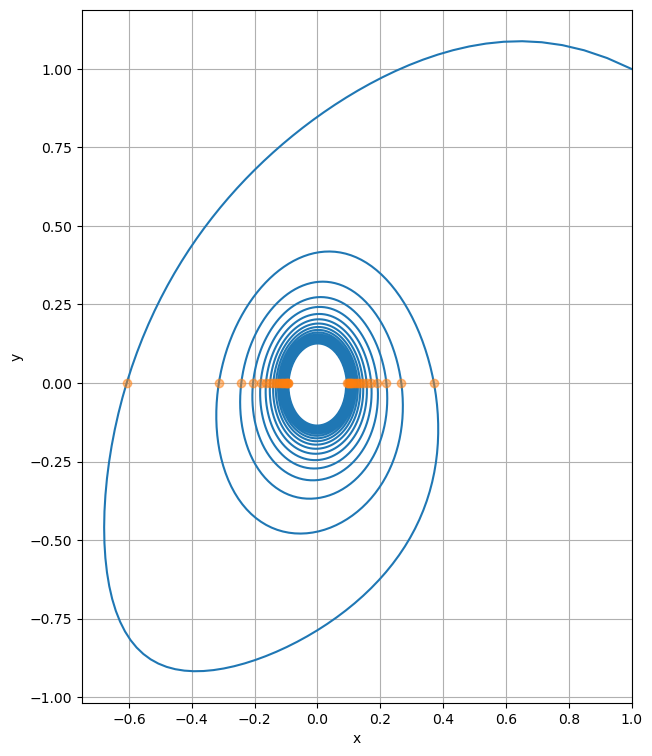

In [5]:
from matplotlib.pylab import plt

fig = plt.figure(figsize=(9, 9))
ax = plt.subplot(111)
ax.set_aspect('equal', adjustable='box')

plt.plot(out[5][:, 0], out[5][:, 1])
plt.plot(ev_x, [0] * len(ev_x), 'o', alpha=.5)

plt.xlabel("x")
plt.ylabel("y")
plt.xlim((-0.75, 1))

plt.grid()

The plot shows how the event detection system indeed fired each time the solution crossed the $x$ axis.

Let us now complicate things a bit: instead of detecting when the solution crosses the $x$ axis, we want to detect when the solution intersects the non-linear curve

$$
y = 1.1 \sin\left( 5x \right).
$$

The only thing we need to change in our setup is the event equation, which will now read

$$
y - 1.1 \sin\left( 5x \right) = 0
$$

rather than simply $y=0$. Additionally, we will also need to store explicitly the $y$ coordinate of the crossing points. Let us take a look at the code:

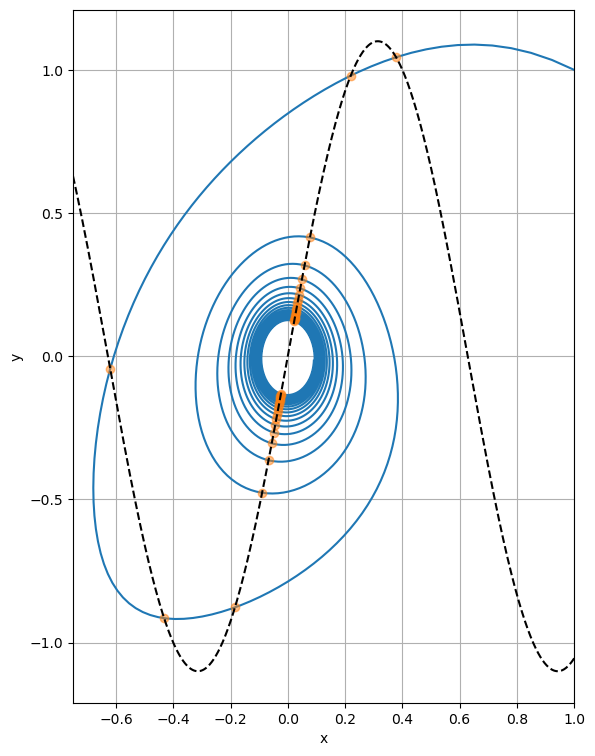

In [6]:
fig = plt.figure(figsize=(9, 9))

# Lists of x/y coordinates for the crossing points.
ev_x = []
ev_y = []

# The (updated) callback function.
def cb(ta, time, d_sgn):
    ta.update_d_output(time)
    ev_x.append(ta.d_output[0])
    ev_y.append(ta.d_output[1])

# Reset the integrator with the new event.
ta = hy.taylor_adaptive(eqns, [1., 1.], nt_events = [hy.nt_event(y - 1.1*hy.sin(5*x), cb)])

# Integrate over a time grid.
out = ta.propagate_grid(grid)

# Plot the results.
ax = plt.subplot(111)
ax.set_aspect('equal', adjustable='box')

plt.plot(out[5][:, 0], out[5][:, 1])
plt.plot(ev_x, ev_y, 'o', alpha = .5)

# Plot also the curve.
xrng = np.linspace(-0.75, 1, 2000)
plt.plot(xrng, 1.1*np.sin(5*xrng), 'k--')

plt.xlabel("x")
plt.ylabel("y")
plt.xlim((-0.75, 1))

plt.grid()

The plot shows again how the event detection system was able to correctly detect the intersections of the solution with the curve.